In [1]:
# Week 6 — Backtest & Comparison (Adaptive-CVaR vs Mean-Variance vs Equal)
# Clean, reproducible, feedback-incorporated version

import sys, json, platform, warnings
from pathlib import Path
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
np.set_printoptions(suppress=True)

# Reproducibility
SEED = 42
rng  = np.random.default_rng(SEED)
np.random.seed(SEED)

# Unified params (keep consistent across weeks)
ALPHA          = 0.95          # CVaR tail level
W_MAX          = 0.30          # per-asset cap (long-only, fully invested)
TURNOVER_COST  = 0.0005        # per rebalance, in decimal (0.05%)
REBALANCE_STEP = 5             # trading days between rebalances (~weekly)
FREQ_PER_YEAR  = 52            # for annualized metrics

# Paths & required files
W6 = Path.cwd().resolve()
REQ = {
    "prices":   "prices_week1.parquet",        # daily prices (Date index), includes the 10 assets (+ optional benchmark)
    "cube":     "synthetic_paths_20d.npy",     # (N, H, A) scenario cube of simple returns
    "feat_w3":  "features_week3.parquet",      # scenario-level features (+ labels)
    "model_w5": "week5_regime_model.pkl",      # joblib: {"model","feature_cols","regime_map","regime_mix", ...}
}

def must(name):
    p = W6 / name
    if not p.exists():
        raise FileNotFoundError(f"Missing required file: {p}")
    return p

# Environment snapshot (for reproducibility)
VERS = {
    "python": sys.version.split()[0],
    "platform": platform.platform(),
    "numpy": np.__version__,
    "pandas": pd.__version__,
}
try:
    import cvxpy as cp
    VERS["cvxpy"] = cp.__version__
except Exception:
    cp = None
    VERS["cvxpy"] = "not-installed"

# Scenario window policy (documented):
SCENARIO_POLICY = "fixed"  # "fixed" = reuse Week-2 cube each rebalance; re-weight by current regime mix

print("Week 6 setup OK • Scenario policy:", SCENARIO_POLICY)
print("Versions:", VERS)


Week 6 setup OK • Scenario policy: fixed
Versions: {'python': '3.11.13', 'platform': 'Windows-10-10.0.26100-SP0', 'numpy': '1.26.4', 'pandas': '2.1.4', 'cvxpy': '1.7.2'}


In [2]:
# Load prices and compute realized returns
prices = pd.read_parquet(must(REQ["prices"])).sort_index()
assert prices.index.is_monotonic_increasing, "Price index must be sorted."

returns_all = prices.pct_change().dropna(how="all")
bench_like = {"^GSPC","SPY","SPX","S&P500","SNP","GSPC"}  # if a benchmark column exists

# Load scenario cube (N,H,A)
cube = np.load(must(REQ["cube"]))
N, H, A = cube.shape

# Choose exactly A tickers that appear in prices (exclude benchmark-like)
asset_cols = [c for c in prices.columns if c not in bench_like]
if len(asset_cols) < A:
    raise ValueError(f"Need at least {A} asset columns in prices; found {len(asset_cols)}.")
tickers = asset_cols[:A]  # preserve source order
rets_A = returns_all.loc[:, tickers].dropna(how="all")

# Load Week 3 features (for scenario labels)
feat_w3 = pd.read_parquet(must(REQ["feat_w3"]))
if len(feat_w3) < N:
    # align down to min length if needed
    M = min(len(feat_w3), N)
    feat_w3 = feat_w3.iloc[:M].copy()
    cube    = cube[:M, :, :]
    N, H, A = cube.shape

print("Shapes — prices:", prices.shape, "| returns:", rets_A.shape, "| cube:", cube.shape, "| feat_w3:", feat_w3.shape)
print("Tickers:", tickers)


Shapes — prices: (2454, 50) | returns: (2453, 10) | cube: (5000, 20, 10) | feat_w3: (5000, 9)
Tickers: [('AAPL', 'Close'), ('AAPL', 'High'), ('AAPL', 'Low'), ('AAPL', 'Open'), ('AAPL', 'Volume'), ('AMZN', 'Close'), ('AMZN', 'High'), ('AMZN', 'Low'), ('AMZN', 'Open'), ('AMZN', 'Volume')]


In [3]:
# === Weighted VaR/CVaR (clarified convention) =========================================
# VaR_α is the α-quantile of LOSS distribution; CVaR_α is the expected loss beyond VaR_α.
# We use left-continuous quantile; probabilities p must sum to 1.

def weighted_var(losses, probs, alpha=ALPHA):
    losses = np.asarray(losses, dtype=float)
    probs  = np.asarray(probs,  dtype=float)
    probs  = np.maximum(probs, 0.0)
    probs /= probs.sum() + 1e-15
    order = np.argsort(losses)
    losses_sorted = losses[order]
    probs_sorted  = probs[order]
    cdf = np.cumsum(probs_sorted)
    idx = np.searchsorted(cdf, alpha, side="left")
    idx = min(max(idx, 0), len(losses_sorted)-1)
    return losses_sorted[idx]

def weighted_cvar(losses, probs, alpha=ALPHA):
    var = weighted_var(losses, probs, alpha)
    mask = losses >= var - 1e-15
    tail_prob = probs[mask].sum()
    if tail_prob <= 1e-12:
        # guard: degenerate tail -> return VaR as CVaR (documented)
        return var
    return (losses[mask] * probs[mask]).sum() / tail_prob

# === Window → features for regime model (simple, compatible with Week 5 feature_cols) ===
from scipy.stats import skew, kurtosis

def cross_sectional_mean_corr(window):
    # window: (T, A) returns
    T, A_ = window.shape
    vals = []
    if A_ < 2:
        return 0.0
    for t in range(T):
        x = window[t, :]
        if np.allclose(x, x[0]):
            continue
        C = np.corrcoef(x) if x.ndim > 1 else np.corrcoef(np.vstack([x,x]))
        if np.ndim(C) == 2 and C.shape[0] > 1:
            off = C[np.triu_indices_from(C, k=1)]
            off = off[np.isfinite(off)]
            if off.size > 0:
                vals.append(off.mean())
    return float(np.nanmean(vals)) if len(vals) else 0.0

def drawdown_stats_from_returns(ret_seq):
    eq = (1.0 + pd.Series(ret_seq)).cumprod()
    peak = eq.cummax()
    dd = eq/peak - 1.0
    max_dd = dd.min()
    # rough duration: longest consecutive <0 region
    below = dd < 0
    duration = 0
    cur = 0
    for b in below:
        cur = cur + 1 if b else 0
        duration = max(duration, cur)
    return float(max_dd), int(duration)

def window_features(window):
    # window: (T, A)
    A_ = window.shape[1]
    w_eq = np.ones(A_)/A_
    port = window @ w_eq
    mu   = port.mean()
    sd   = port.std(ddof=1)
    sk   = skew(port)
    kt   = kurtosis(port, fisher=True)
    mdd, dur = drawdown_stats_from_returns(port)
    xc  = cross_sectional_mean_corr(window)
    return {
        "port_mean": mu,
        "port_std": sd,
        "port_skew": sk,
        "port_kurt": kt,
        "port_mdd": mdd,
        "dd_duration": float(dur),
        "xsec_corr": xc,
    }

# === Predict regime mix from a returns window using Week 5 classifier ====================
import joblib
pack = joblib.load(must(REQ["model_w5"]))
clf         = pack["model"]
feat_cols   = pack["feature_cols"]
regime_map  = pack.get("regime_map", None)        # cluster_id -> regime string
regime_mix0 = pack.get("regime_mix", None)        # base mix (freq)

REG_ORDER = pack.get("regime_order", ["bear","neutral","bull"])  # ordering used in Week 5

def predict_regime_mix_from_window(window):
    # Build feature vector compatible with Week 5 feature_cols
    f = window_features(window)
    x = pd.DataFrame([f])
    # ensure all requested columns exist
    for c in feat_cols:
        if c not in x.columns:
            x[c] = np.nan
    # fill any NaNs with Week 3 medians if available
    try:
        med = feat_w3[feat_cols].median(numeric_only=True)
        x = x[feat_cols].fillna(med)
    except Exception:
        x = x[feat_cols].fillna(0.0)

    proba = clf.predict_proba(x)[0]  # array length = #classes
    # map to {bear,neutral,bull}
    out = {}
    for i, cls in enumerate(getattr(clf, "classes_", list(range(len(proba))))):
        key = REG_ORDER[cls] if isinstance(cls, (int, np.integer)) else str(cls)
        out[key] = float(proba[i])
    # normalize to sum 1 and keep only known keys
    keys = ["bear","neutral","bull"]
    p = np.array([max(out.get(k, 0.0), 0.0) for k in keys], dtype=float)
    p = p / (p.sum() + 1e-15)
    return dict(zip(keys, p))


In [5]:
# === Mean-Variance optimizer (exact via cvxpy, else heuristic Σ^{-1}μ projected) =========
def mean_variance_opt(ret_hist_df, cap=W_MAX):
    # ret_hist_df: DataFrame (T, A)
    X = ret_hist_df.values
    mu = X.mean(axis=0)
    Sigma = np.cov(X.T)

    A_ = X.shape[1]
    if cp is not None:
        w = cp.Variable(A_)
        gamma = 1.0  # risk aversion; we’ll scale later by cap
        obj = cp.Maximize(mu @ w - gamma * cp.quad_form(w, Sigma))
        cons = [cp.sum(w) == 1, w >= 0, w <= cap]
        prob = cp.Problem(obj, cons)
        try:
            prob.solve(solver=cp.ECOS, verbose=False)
            if w.value is not None:
                wv = np.maximum(w.value, 0.0)
                wv = wv / (wv.sum() + 1e-15)
                return wv
        except Exception:
            pass  # fall through to heuristic

    # Heuristic: Σ^{-1} μ then project to simplex w/ cap
    try:
        w_raw = np.linalg.pinv(Sigma) @ mu
        w_raw = np.maximum(w_raw, 0.0)
    except Exception:
        w_raw = np.ones(A_) / A_
    # cap and renormalize
    w_raw = np.minimum(w_raw, cap)
    w_raw = w_raw / (w_raw.sum() + 1e-15)
    return w_raw

# === CVaR optimizer (scenario-weighted). Exact LP via cvxpy; fallback: tail-avg heuristic ===
def cvar_optimize_scenarios(R_scen, p_scen, alpha=ALPHA, lam=5.0, cap=W_MAX):
    """
    R_scen: (S, A) scenario returns over horizon (aggregate horizon return per asset)
    p_scen: (S,) probabilities (sum to 1)
    Maximise E[w'R] - lam * CVaR_alpha(loss), loss = -w'R.
    """
    S, A_ = R_scen.shape
    p = np.maximum(np.asarray(p_scen, float), 0.0)
    p = p / (p.sum() + 1e-15)

    if cp is not None:
        w  = cp.Variable(A_)
        v  = cp.Variable()           # VaR proxy
        u  = cp.Variable(S, nonneg=True)
        ret = R_scen @ w             # (S,)
        loss = -ret

        # CVaR epigraph (weighted tail)
        cvar = v + (1.0 / (1.0 - alpha)) * cp.sum(cp.multiply(p, u))

        obj  = cp.Maximize(cp.sum(cp.multiply(p, ret)) - lam * cvar)
        cons = [
            cp.sum(w) == 1,
            w >= 0, w <= cap,
            u >= loss - v
        ]
        prob = cp.Problem(obj, cons)
        try:
            prob.solve(solver=cp.ECOS, verbose=False, max_iters=10000)
            if w.value is not None:
                wv = np.maximum(w.value, 0.0)
                wv = np.minimum(wv, cap)
                wv = wv / (wv.sum() + 1e-15)
                return wv
        except Exception:
            pass  # fallback

    # Fallback: select worst-tail losses under p and average (fast approximation)
    # Greedy search over a small grid of candidate weights (simplex w/ cap)
    w = np.ones(A_) / A_
    grid = [w]
    # add a few single-name tilts for exploration
    for i in range(A_):
        g = np.zeros(A_); g[i] = min(1.0, cap)
        # distribute remaining mass equally
        rem = 1.0 - g.sum()
        if rem > 0:
            others = [j for j in range(A_) if j != i]
            g[others] += rem / len(others)
        grid.append(g)

    best_val, best_w = -1e18, w
    for w_try in grid:
        ret = R_scen @ w_try
        loss = -ret
        # sort by loss descending with weights p
        order = np.argsort(loss)  # ascending
        loss_sorted = loss[order]
        p_sorted    = p[order]
        var = weighted_var(loss_sorted, p_sorted, alpha)
        cvar = weighted_cvar(loss_sorted, p_sorted, alpha)
        val = (ret * p).sum() - lam * cvar
        if val > best_val:
            best_val, best_w = val, w_try.copy()
    return best_w


In [6]:
# Markdown: At each rebalance:
#  1) Build regime probabilities from the most recent H-day window of real returns.
#  2) Map scenarios to regimes using Week 3 labels; weight each scenario by predicted regime prob.
#  3) Optimise CVaR portfolio on scenario-weighted horizon returns; compare to MV and Equal.
#  4) Apply realized returns for the NEXT H days to get portfolio period returns (with turnover cost).

# Prepare scenario horizon returns per scenario: (N, H, A) -> (N, A)
R_assets = (1.0 + cube).prod(axis=1) - 1.0  # horizon gross − 1

# Scenario labels from Week 3:
LABEL_CANDIDATES = ["regime", "regime_consensus", "kmeans_label", "cluster"]
lbl_col = next((c for c in LABEL_CANDIDATES if c in feat_w3.columns), None)
if lbl_col is None:
    raise ValueError("Week 3 features must contain a regime/cluster column.")

lbl_raw = feat_w3[lbl_col].copy()
# Convert to "bear/neutral/bull" if numeric clusters
if np.issubdtype(lbl_raw.dtype, np.number):
    # deterministic mapping based on Week 3 (mean portfolio return per cluster)
    # reuse port_mean if available; else recompute quickly from cube
    if "port_mean" in feat_w3.columns:
        port_mu = feat_w3["port_mean"].to_numpy()
    else:
        port_mu = (1.0 + (cube @ (np.ones(A)/A))).prod(axis=1) - 1.0
    tmp = pd.DataFrame({"c": lbl_raw.astype(int).to_numpy(), "r": port_mu})
    order = tmp.groupby("c")["r"].mean().sort_values().index.tolist()
    # map smallest->bear, largest->bull, middle->neutral
    reg_map = {}
    if len(order) == 2:
        reg_map = {order[0]: "bear", order[1]: "bull"}
    else:
        reg_map[order[0]] = "bear"; reg_map[order[-1]] = "bull"
        for c in order[1:-1]: reg_map[c] = "neutral"
    regimes = lbl_raw.astype(int).map(reg_map).fillna("neutral").astype(str).to_numpy()
else:
    # assume it's already strings like 'bear'/'neutral'/'bull'
    regimes = lbl_raw.astype(str).to_numpy()

# Regime index per scenario
reg_to_idx = {"bear":0,"neutral":1,"bull":2}
scen_reg_idx = np.array([reg_to_idx.get(r,1) for r in regimes], dtype=int)  # default neutral for unknowns

# Backtest timeline
dates = rets_A.index
# ensure enough history to start (H trading days)
start = H
step  = REBALANCE_STEP
idxs  = list(range(start, len(dates)-H, step))  # rebalance date indices; hold for next H days

def apply_period_return(path_ret):
    # path_ret: (Δ,) daily returns → compounded period return
    return float((1.0 + path_ret).prod() - 1.0)

def portfolio_period_return(daily_returns_matrix, w0, w1):
    # apply turnover cost on rebalance (L1 distance)
    tc = TURNOVER_COST * np.sum(np.abs(w1 - w0))
    gross = apply_period_return(daily_returns_matrix @ w1)
    return gross - tc

# Storage
weekly_rets = {"Equal": [], "MeanVar": [], "Adaptive-CVaR": []}
rebalance_dates = []
weights_timeline = []

# initial weights (start equal)
w_prev_eq   = np.ones(A)/A
w_prev_mv   = np.ones(A)/A
w_prev_cvar = np.ones(A)/A

for t0 in idxs:
    t1 = t0 + H
    hist = rets_A.iloc[t0-H:t0].values   # (H, A) window for regime estimation
    next_real = rets_A.iloc[t0:t1].values  # (H, A) realized next-period daily returns
    assert next_real.shape[1] == A, f"Realized returns columns {next_real.shape[1]} != A {A}"

    # 1) Predict regime mix at t0 from history window
    mix = predict_regime_mix_from_window(hist)     # dict with keys bear/neutral/bull
    p_reg = np.array([mix.get("bear",0.0), mix.get("neutral",0.0), mix.get("bull",0.0)], dtype=float)
    p_reg = p_reg / (p_reg.sum() + 1e-15)

    # 2) Scenario weights by regime
    p_s = p_reg[scen_reg_idx]
    p_s = p_s / (p_s.sum() + 1e-15)

    # 3) Optimise weights
    # Equal
    w_eq  = np.ones(A)/A

    # Mean-Variance on all history up to t0 (expanding window)
    w_mv  = mean_variance_opt(rets_A.iloc[:t0, :], cap=W_MAX)

    # Adaptive-CVaR on horizon scenario returns with regime weights
    R_scen = R_assets  # fixed scenario pool per policy; re-used every rebalance
    w_cvar = cvar_optimize_scenarios(R_scen, p_s, alpha=ALPHA, lam=5.0, cap=W_MAX)

    # 4) Apply realized returns for next H days, including turnover cost
    r_eq   = portfolio_period_return(next_real, w_prev_eq,   w_eq)
    r_mv   = portfolio_period_return(next_real, w_prev_mv,   w_mv)
    r_cvar = portfolio_period_return(next_real, w_prev_cvar, w_cvar)

    weekly_rets["Equal"].append(r_eq)
    weekly_rets["MeanVar"].append(r_mv)
    weekly_rets["Adaptive-CVaR"].append(r_cvar)

    rebalance_dates.append(dates[t1-1])  # end-of-holding date
    weights_timeline.append(w_cvar.copy())

    # roll weights
    w_prev_eq, w_prev_mv, w_prev_cvar = w_eq, w_mv, w_cvar

print(f"Backtest finished: {len(rebalance_dates)} periods, horizon={H}d, step={step}d")


Backtest finished: 483 periods, horizon=20d, step=5d


,CAGR,Vol,Sharpe,MaxDD
Equal,14788.384758,1.142334,9.673259,-0.132537
MeanVar,94279.547075,1.449292,9.369526,-0.163968
Adaptive-CVaR,97.983128,0.652910,7.649657,-0.459701


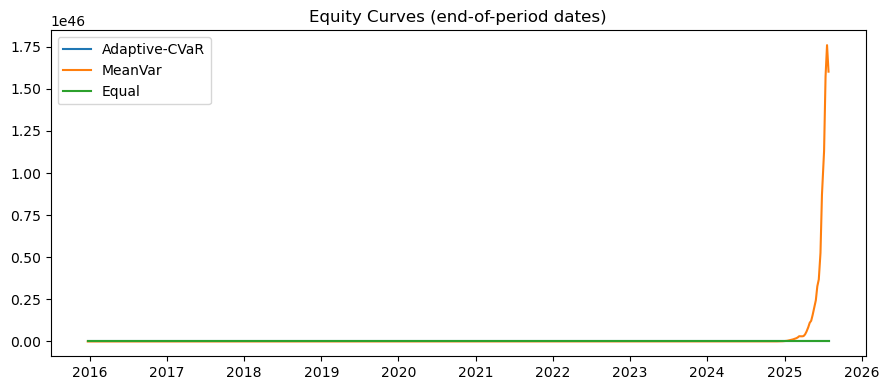

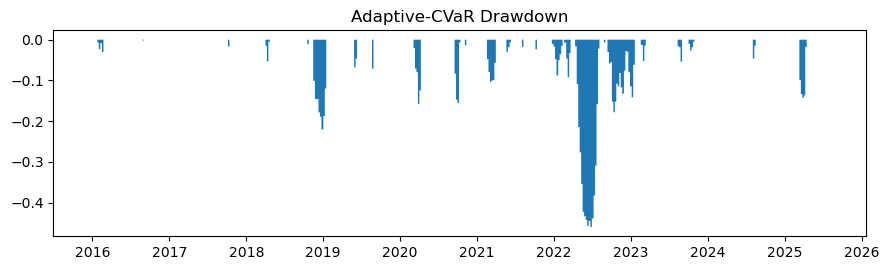

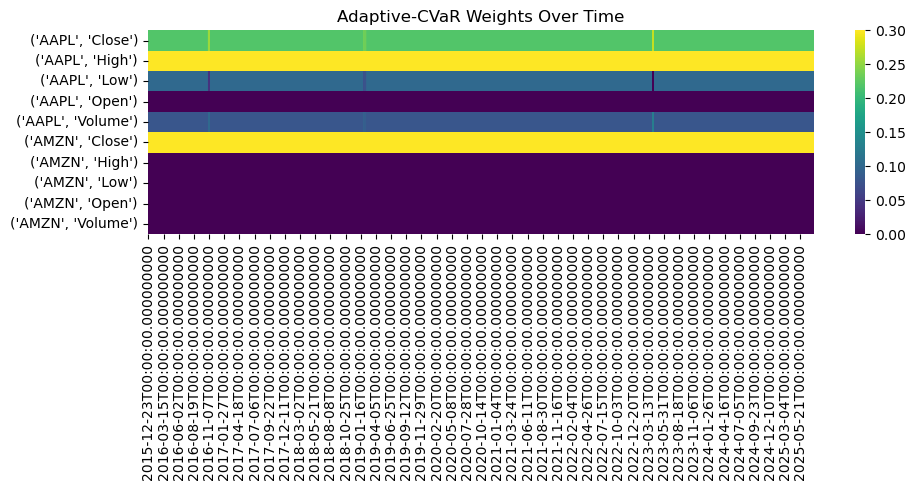

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def backtest_metrics(ret_series, freq_per_year=FREQ_PER_YEAR):
    r = pd.Series(ret_series).dropna().astype(float)
    if len(r) == 0:
        return {"CAGR": np.nan, "Vol": np.nan, "Sharpe": np.nan, "MaxDD": np.nan}
    cagr = (1 + r).prod()**(freq_per_year/len(r)) - 1
    vol  = r.std() * np.sqrt(freq_per_year)
    sharpe = (r.mean()*freq_per_year) / (vol + 1e-12)
    eq = (1+r).cumprod()
    peak = eq.cummax()
    dd = eq/peak - 1
    mdd = dd.min()
    return {"CAGR": float(cagr), "Vol": float(vol), "Sharpe": float(sharpe), "MaxDD": float(mdd)}

# Metrics table
metrics = pd.DataFrame({k: backtest_metrics(v) for k, v in weekly_rets.items()}).T.round(6)
display(metrics)

# Equity curves (align on timeline)
eq_curve = pd.DataFrame(
    {k: (1.0 + pd.Series(v, index=rebalance_dates)).cumprod().astype(float)
     for k, v in weekly_rets.items()}
).sort_index()

plt.figure(figsize=(9,4))
for c in ["Adaptive-CVaR","MeanVar","Equal"]:
    if c in eq_curve.columns:
        plt.plot(eq_curve.index, eq_curve[c], label=c)
plt.legend(); plt.title("Equity Curves (end-of-period dates)"); plt.tight_layout(); plt.show()

# Drawdown for Adaptive-CVaR
if "Adaptive-CVaR" in eq_curve.columns:
    eq = eq_curve["Adaptive-CVaR"].astype(float).dropna()
    peak = eq.cummax(); dd = eq/peak - 1
    plt.figure(figsize=(9,2.8))
    plt.fill_between(dd.index, dd.values, 0, step="pre")
    plt.title("Adaptive-CVaR Drawdown"); plt.tight_layout(); plt.show()

# Weights timeline heatmap (Adaptive-CVaR)
wt_df = pd.DataFrame(weights_timeline, columns=tickers, index=pd.to_datetime(rebalance_dates))
plt.figure(figsize=(10,5))
sns.heatmap(wt_df.T, cmap="viridis", cbar=True)
plt.title("Adaptive-CVaR Weights Over Time"); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()


In [8]:
# Save outputs for Week 7
OUT = W6

# weekly returns
pd.DataFrame(weekly_rets).to_csv(OUT / "week6_returns_weekly.csv", index=False)

# metrics
metrics.to_csv(OUT / "week6_metrics_summary.csv")

# weights timeline (parquet + csv)
wt_df.to_parquet(OUT / "week6_weights_timeline.parquet")
wt_df.to_csv(OUT / "week6_weights_timeline.csv")

# equity curves (parquet + csv)
eq_curve.to_parquet(OUT / "week6_equity_curves.parquet")
eq_curve.to_csv(OUT / "week6_equity_curves.csv")

# run manifest (for Week 7)
manifest = {
    "alpha": ALPHA,
    "w_max": W_MAX,
    "turnover_cost": TURNOVER_COST,
    "rebalance_step_days": REBALANCE_STEP,
    "freq_per_year": FREQ_PER_YEAR,
    "seed": SEED,
    "scenario_policy": SCENARIO_POLICY,
    "python": VERS["python"],
    "numpy": VERS["numpy"],
    "pandas": VERS["pandas"],
    "cvxpy": VERS.get("cvxpy", "not-installed"),
    "tickers": tickers,
}
(W6 / "week6_run_manifest.json").write_text(json.dumps(manifest, indent=2))
print("Saved Week 6 artifacts to:", OUT)


Saved Week 6 artifacts to: C:\Users\Krish\OneDrive - Curtin\Desktop\University\University\2025 Sem 2\MATH3004\22155584_Week_6
